In [1]:
# import libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pathlib
from pathlib import Path
import os
import seaborn as sns
import datetime
import shapely
from shapely.geometry import shape, Point, LineString, Polygon

# set the working directory
BASE_DIR = Path.cwd()
print(BASE_DIR)

#set the project directory
project_folder = BASE_DIR.parent.parent
print(project_folder)

/tmp/pycharm_project_316/BEAM_Freight/Notebooks/GCE
/tmp/pycharm_project_316/BEAM_Freight


/home/goyal/.virtualenvs/venv_lbl_gce/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_88707/2539677943.py:3: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/lates

In [2]:
# Upload output in the respective bucket storage in the following path
# "gs://beam-core-outputs/output/city_name/simulation_name/Output/*" or
# "gs://beam-core-outputs/output/city_name/simulation_name/Output/plot/*" or

from google.cloud import storage
# Upload file to Google Cloud service
def upload_blob(_bucket_name, _source_file_name, _destination_blob_name):
    """Uploads a file to the bucket."""
    # The ID of your GCS bucket
    # bucket_name = "your-bucket-name"
    # The path to your file to upload
    # source_file_name = "local/path/to/file"
    # The ID of your GCS object
    # destination_blob_name = "storage-object-name"
    storage_client = storage.Client()
    bucket = storage_client.bucket(_bucket_name)
    blob = bucket.blob(_destination_blob_name)
    # Optional: set a generation-match precondition to avoid potential race conditions
    # and data corruptions. The request to upload is aborted if the object's
    # generation number does not match your precondition. For a destination
    # object that does not yet exist, set the if_generation_match precondition to 0.
    # If the destination object already exists in your bucket, set instead a
    # generation-match precondition using its generation number.
    generation_match_precondition = 0
    blob.upload_from_filename(_source_file_name, if_generation_match=generation_match_precondition)
    print(
        f"File {_source_file_name} uploaded to {_destination_blob_name}."
    )

def delete_blob(_bucket_name, _blob_name):
    """Deletes a blob from the bucket."""
    # bucket_name = "your-bucket-name"
    # blob_name = "your-object-name"

    storage_client = storage.Client()

    bucket = storage_client.bucket(_bucket_name)
    blob = bucket.blob(_blob_name)
    generation_match_precondition = None

    # Optional: set a generation-match precondition to avoid potential race conditions
    # and data corruptions. The request to delete is aborted if the object's
    # generation number does not match your precondition.
    blob.reload()  # Fetch blob metadata to use in generation_match_precondition.
    generation_match_precondition = blob.generation

    blob.delete(if_generation_match=generation_match_precondition)

    print(f"Blob {_blob_name} deleted.")

In [3]:
# Basic Reference Points
city_name="austin"
gcloud_bucket = "gs://beam-core-outputs/output/austin"
iter_no = "0"
linkstats_file_path = f"{iter_no}.linkstats.csv.gz"
network_file_path = "network.csv.gz"
event_files_path = f"{iter_no}.events.csv.gz"
simulation_name = "austin-base-with-freight-2018__2023-04-14_16-11-13_yoq"
analysis_type = "Freight"
#Check if the folder exist, if not create it.
try:
    pathlib.Path(project_folder.joinpath("Output", city_name, simulation_name, analysis_type, "plot")).mkdir(parents=True, exist_ok=False)
except:
    pass
# load parameter and data for validation
meter_to_mile = 0.000621371
percent_of_samples = 0.1
mps_to_mph = 2.23694

In [4]:
# modeled_vmt = pd.read_csv(project_folder.joinpath("Data", city_name, simulation_name,linkstats_file_path), compression="gzip", low_memory=True)
modeled_vmt = pd.read_csv(f"{gcloud_bucket}/{simulation_name}/ITERS/it.{iter_no}/{linkstats_file_path}", compression="gzip", low_memory=True)
observed_vmt = pd.read_csv(project_folder.joinpath("Output",city_name, simulation_name, analysis_type, "austin_hpms_inventory.csv"))
model_network = pd.read_csv(project_folder.joinpath("Output",city_name, simulation_name, analysis_type, "beam_network_by_county.csv"))
modeled_vmt_by_hour = modeled_vmt.groupby('hour')[['volume']].sum()

observed_vmt.loc[:, 'LN_MILES'] = meter_to_mile * observed_vmt.loc[:, 'Through_La'] * observed_vmt.loc[:, 'length']
total_lane_mile_observed = observed_vmt['LN_MILES'].sum()

model_network = model_network.drop_duplicates(subset=['linkId'])
model_network.loc[:, 'lane_mile'] = meter_to_mile * model_network.loc[:, 'linkLength'] * model_network.loc[:, 'numberOfLanes']
total_lane_mile_modeled = model_network['lane_mile'].sum()

In [5]:
# filter modeled network
model_vmt_24_hour = modeled_vmt.loc[(modeled_vmt['hour'] <= 28) & (modeled_vmt['hour'] >= 5)]
model_vmt_24_hour.loc[model_vmt_24_hour['hour']>=24, 'hour'] -= 24
model_network['fromNodeId'] = model_network['fromNodeId'].astype(int)
model_network['toNodeId'] = model_network['toNodeId'].astype(int)
model_vmt_24_hour = pd.merge(model_vmt_24_hour, model_network,
                             left_on = ['link', 'from', 'to'],
                             right_on = ['linkId', 'fromNodeId', 'toNodeId'], how = 'left')

model_vmt_24_hour.loc[:, 'lane_mile'] = meter_to_mile * model_vmt_24_hour.loc[:, 'numberOfLanes'] * model_vmt_24_hour.loc[:, 'linkLength'] / 24.0
total_lane_mile_with_cars = model_vmt_24_hour.loc[:, 'lane_mile'].sum()

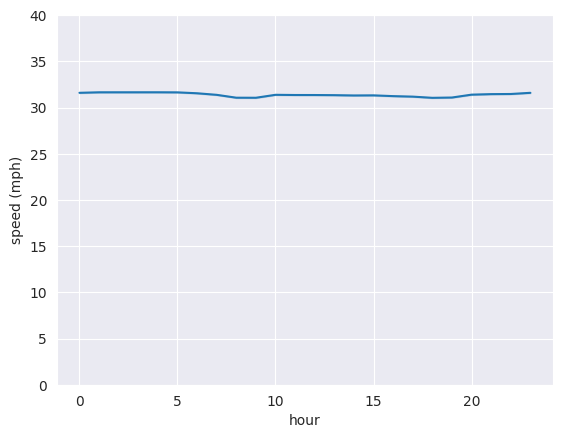

File /tmp/pycharm_project_316/BEAM_Freight/Output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Freight/plot/modeled_speed_for_all_links.png uploaded to output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Output/plot/modeled_speed_for_all_links.png.


In [6]:
demand_scaling = 1/percent_of_samples
# print(demand_scaling)
model_vmt_24_hour.loc[:, 'VMT'] = demand_scaling * meter_to_mile * model_vmt_24_hour.loc[:, 'linkLength'] * model_vmt_24_hour.loc[:, 'volume']
# model_vmt_24_hour.loc[:, 'travel_time (hr)'] = model_vmt_24_hour.loc[:, 'linkLength'] /3600

model_vmt_24_hour.loc[:, 'speed'] = model_vmt_24_hour.loc[:, 'linkLength'] / model_vmt_24_hour.loc[:, 'traveltime']
model_vmt_24_hour.loc[:, 'speed (mph)'] = mps_to_mph * model_vmt_24_hour.loc[:, 'speed']
model_vmt_24_hour.loc[:, 'volume'] *= demand_scaling
sns.lineplot(x = 'hour', y = 'speed (mph)', data = model_vmt_24_hour, errorbar=('ci', 95))
plt.ylim([0, 40])
plt_file_name=f"modeled_speed_for_all_links.png"
plt.savefig(project_folder.joinpath("Output", city_name, simulation_name, analysis_type, "plot", plt_file_name), dpi=600)
# plt.savefig('plot/' + scenario_name + '/modeled_speed_for_all_links.png', dpi = 200)
plt.show()

bucket_name = "beam-core-outputs"
source_file_name = project_folder.joinpath("Output", city_name, simulation_name, analysis_type, "plot",plt_file_name)
destination_blob_name = f"output/{city_name}/{simulation_name}/Output/plot/{plt_file_name}"
# Check if the file exist in the bucket. If "Yes", delete
try:
    delete_blob(_bucket_name=bucket_name, _blob_name=destination_blob_name)
except:
    pass
# and upload the file
upload_blob(bucket_name, source_file_name, destination_blob_name)

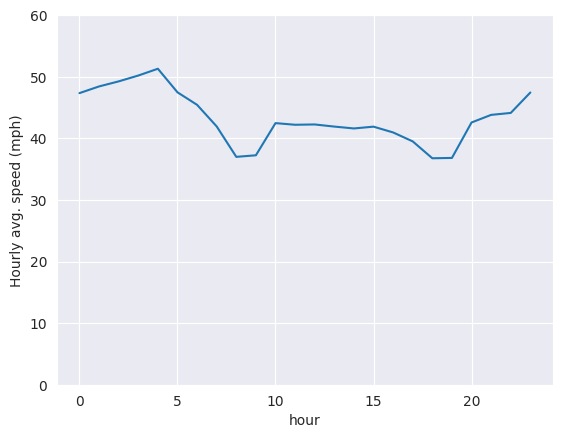

File /tmp/pycharm_project_316/BEAM_Freight/Output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Freight/plot/avg_speed_for_all_links.png uploaded to output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Output/plot/avg_speed_for_all_links.png.


In [7]:
# SUMMARIZE HOURLY SPEED
model_vmt_24_hour.loc[:, 'VMT'] =  meter_to_mile * model_vmt_24_hour.loc[:, 'linkLength'] * model_vmt_24_hour.loc[:, 'volume']
model_vmt_24_hour.loc[:, 'VHT'] =  model_vmt_24_hour.loc[:, 'traveltime'] * model_vmt_24_hour.loc[:, 'volume'] / 3600.0
model_avg_speed = model_vmt_24_hour.groupby('hour')[['VMT','VHT']].sum()
model_avg_speed = model_avg_speed.reset_index()
model_avg_speed.loc[:, 'speed'] = model_avg_speed.loc[:, 'VMT'] / model_avg_speed.loc[:, 'VHT']
model_avg_speed.to_csv(project_folder.joinpath("Output", city_name, simulation_name, analysis_type, "avg_speed_whole_network.csv"))
sns.lineplot(x = 'hour', y = 'speed', data = model_avg_speed, errorbar=('ci', 95))
plt.ylim([0, 60])
plt.ylabel('Hourly avg. speed (mph)')
plt_file_name="avg_speed_for_all_links.png"
plt.savefig(project_folder.joinpath("Output", city_name, simulation_name, analysis_type, "plot","avg_speed_for_all_links.png"), dpi=600)
plt.show()

bucket_name = "beam-core-outputs"
source_file_name = project_folder.joinpath("Output", city_name, simulation_name, analysis_type, "plot",plt_file_name)
destination_blob_name = f"output/{city_name}/{simulation_name}/Output/plot/{plt_file_name}"
# Check if the file exist in the bucket. If "Yes", delete
try:
    delete_blob(_bucket_name=bucket_name, _blob_name=destination_blob_name)
except:
    pass
# and upload the file
upload_blob(bucket_name, source_file_name, destination_blob_name)

MemoryError: Unable to allocate 2.63 EiB for an array with shape (379050845949513024,) and data type float64

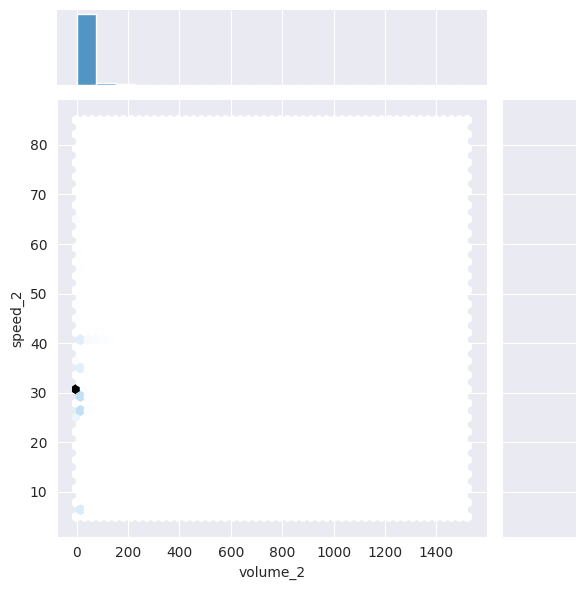

In [8]:
# create 24 pivot table for speed and volume
speed_by_hour = pd.pivot_table(model_vmt_24_hour, values='speed (mph)',
                               index=['linkId', 'fromNodeId', 'toNodeId'],
                               columns=['hour'])
speed_by_hour.columns = ['speed_' + str(i+1) for i in range(24)]
speed_by_hour = speed_by_hour.reset_index()
# print(speed_by_hour.head(5))

volume_by_hour = pd.pivot_table(model_vmt_24_hour, values='volume',
                                index=['linkId', 'fromNodeId', 'toNodeId'],
                                columns=['hour'])
volume_by_hour.columns = ['volume_' + str(i+1) for i in range(24)]
volume_by_hour = volume_by_hour.reset_index()

combined_metric_by_hour = pd.merge(speed_by_hour, volume_by_hour,
                                   on = ['linkId', 'fromNodeId', 'toNodeId'],
                                   how = 'outer')
combined_metric_by_hour.head(5)
combined_metric_by_hour.to_csv(project_folder.joinpath("Output", city_name, simulation_name, analysis_type,"processed_linkstats.csv"),index = False)

sns.jointplot(x = 'volume_2', y = 'speed_2', kind="hex", data = combined_metric_by_hour)
plt.xlim([0,2000])
# plt.ylabel('count of households')
# plt.xticks(rotation=0, ha='center')
# plt.ylabel('count of households')
# plt.title('Total households comparison')
plt_file_name="combined_metric_by_hour.png"
plt.savefig(project_folder.joinpath("Output", city_name, simulation_name, analysis_type, "plot","combined_metric_by_hour.png"), dpi = 600, bbox_inches = 'tight')

bucket_name = "beam-core-outputs"
source_file_name = project_folder.joinpath("Output", city_name, simulation_name, analysis_type, "plot",plt_file_name)
destination_blob_name = f"output/{city_name}/{simulation_name}/Output/plot/{plt_file_name}"
# Check if the file exist in the bucket. If "Yes", delete
try:
    delete_blob(_bucket_name=bucket_name, _blob_name=destination_blob_name)
except:
    pass
# and upload the file
upload_blob(bucket_name, source_file_name, destination_blob_name)

In [9]:
observed_vmt.loc[:, 'DVMT'] = meter_to_mile * observed_vmt.loc[:, 'AADT'] * observed_vmt.loc[:, 'length']
observed_vmt.loc[:, 'DTRKVMT'] = meter_to_mile * (observed_vmt.loc[:, 'AADT_Singl']  + observed_vmt.loc[:, 'AADT_Combi']) * observed_vmt.loc[:, 'length']
observed_vmt.loc[:, 'PVMT'] = observed_vmt.loc[:, 'DVMT'] - observed_vmt.loc[:, 'DTRKVMT']

# print(observed_vmt[['DVMT', 'DTRKVMT', 'PVMT']].sum())

In [10]:
# assign roadway classification to modeled network,
# ref: https://wiki.openstreetmap.org/wiki/User:UltimateRiff/HFCS
modeled_roadtype = model_vmt_24_hour.attributeOrigType.unique()
modeled_roadtype_lookup = {'tertiary': 'Minor collector',
                           'trunk_link': 'Freeway and major arterial',
                           'residential': 'Local',
                           'track': 'Local',
                           'footway': 'Local',
                           'motorway': 'Freeway and major arterial',
                           'secondary': 'Major collector',
                           'unclassified': 'Local',
                           'path': 'Local',
                           'secondary_link': 'Major collector',
                           'primary': 'Minor arterial',
                           'motorway_link': 'Freeway and major arterial',
                           'primary_link': 'Minor arterial',
                           'trunk': 'Freeway and major arterial',
                           'pedestrian': 'Local',
                           'tertiary_link': 'Minor collector',
                           'cycleway': 'Local',
                           np.nan: 'Local',
                           'steps': 'Local',
                           'living_street': 'Local',
                           'bus_stop': 'Local',
                           'corridor': 'Local',
                           'road': 'Local',
                           'bridleway': 'Local'}

observed_roadtype_lookup = {1: 'Freeway and major arterial',
                            2: 'Freeway and major arterial',
                            3: 'Freeway and major arterial',
                            4: 'Minor arterial',
                            5: 'Major collector',
                            6: 'Minor collector',
                            7: 'Local'}
model_vmt_24_hour.loc[:, 'road_class'] = model_vmt_24_hour.loc[:, 'attributeOrigType'].map(modeled_roadtype_lookup)
observed_vmt.loc[:, 'road_class'] = observed_vmt.loc[:, 'F_System'].map(observed_roadtype_lookup)
# print(modeled_roadtype)

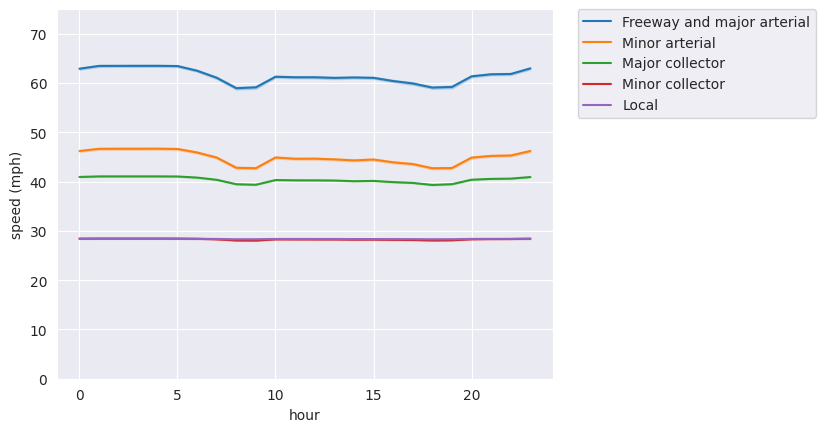

File /tmp/pycharm_project_316/BEAM_Freight/Output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Freight/plot/modeled_speed_by_roadtype.png uploaded to output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Output/plot/modeled_speed_by_roadtype.png.


In [11]:
orders = ['Freeway and major arterial', 'Minor arterial', 'Major collector', 'Minor collector', "Local"]
# sns.color_palette("colorblind")

sns.lineplot(x = 'hour', y = 'speed (mph)', hue = 'road_class', data = model_vmt_24_hour,hue_order=orders, errorbar=('ci',98))
sns.set_palette("colorblind")
plt.ylim([0, 75])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt_file_name="modeled_speed_by_roadtype.png"
plt.savefig(project_folder.joinpath("Output", city_name, simulation_name, analysis_type,"plot",plt_file_name),
            dpi = 600, bbox_inches= 'tight')
plt.show()

bucket_name = "beam-core-outputs"
source_file_name = project_folder.joinpath("Output", city_name, simulation_name, analysis_type, "plot",plt_file_name)
destination_blob_name = f"output/{city_name}/{simulation_name}/Output/plot/{plt_file_name}"
# Check if the file exist in the bucket. If "Yes", delete
try:
    delete_blob(_bucket_name=bucket_name, _blob_name=destination_blob_name)
except:
    pass
# and upload the file
upload_blob(bucket_name, source_file_name, destination_blob_name)

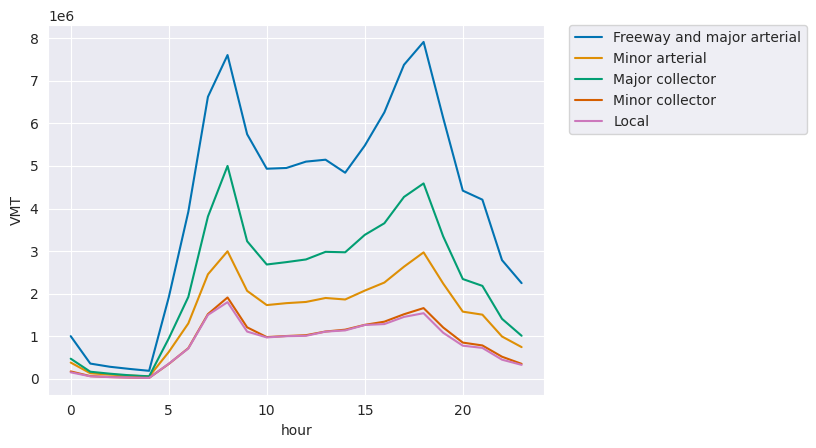

File /tmp/pycharm_project_316/BEAM_Freight/Output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Freight/plot/modeled_VMT_by_hour_roadtype.png uploaded to output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Output/plot/modeled_VMT_by_hour_roadtype.png.


In [12]:
model_vmt_by_hour_roadtype = model_vmt_24_hour.groupby(['hour', 'road_class'])[['VMT']].sum()
model_vmt_by_hour_roadtype = model_vmt_by_hour_roadtype.reset_index()
sns.lineplot(x = 'hour', y = 'VMT', hue = 'road_class',data = model_vmt_by_hour_roadtype, errorbar = None, hue_order=orders)
# plt.ylim([0, 75])
plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt_file_name = 'modeled_VMT_by_hour_roadtype.png'
plt.savefig(project_folder.joinpath("Output", city_name, simulation_name, analysis_type,"plot", plt_file_name),
            dpi = 600, bbox_inches= 'tight')
plt.show()

bucket_name = "beam-core-outputs"
source_file_name = project_folder.joinpath("Output", city_name, simulation_name, analysis_type, "plot",plt_file_name)
destination_blob_name = f"output/{city_name}/{simulation_name}/Output/plot/{plt_file_name}"
# Check if the file exist in the bucket. If "Yes", delete
try:
    delete_blob(_bucket_name=bucket_name, _blob_name=destination_blob_name)
except:
    pass
# and upload the file
upload_blob(bucket_name, source_file_name, destination_blob_name)

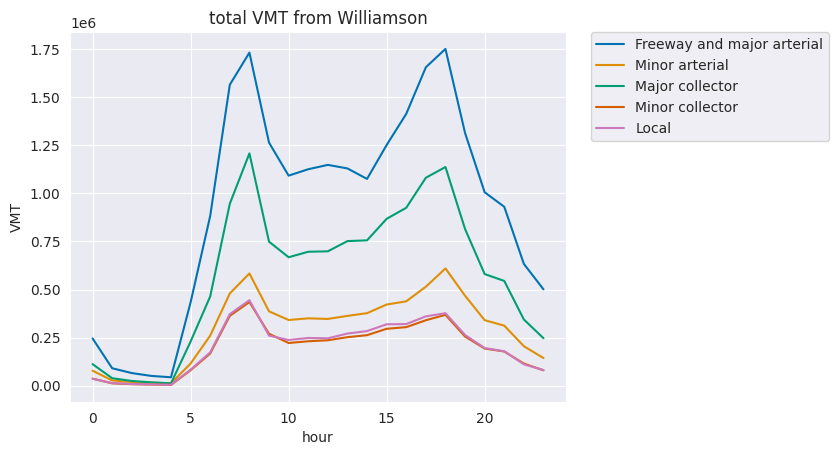

File /tmp/pycharm_project_316/BEAM_Freight/Output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Freight/plot/modeled_VMT_by_hour_Williamson.png uploaded to output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Output/plot/modeled_VMT_by_hour_Williamson.png.


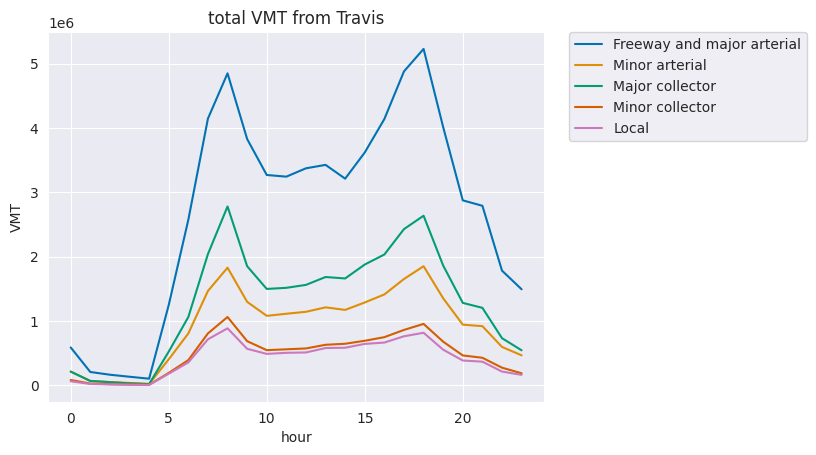

File /tmp/pycharm_project_316/BEAM_Freight/Output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Freight/plot/modeled_VMT_by_hour_Travis.png uploaded to output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Output/plot/modeled_VMT_by_hour_Travis.png.


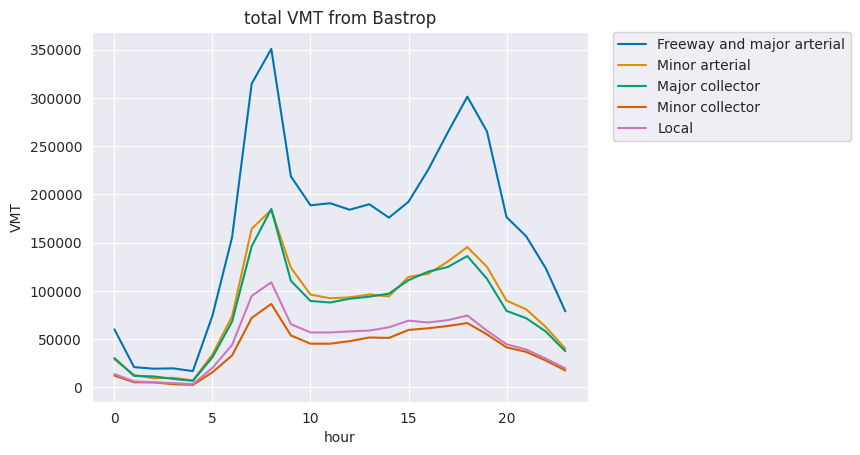

File /tmp/pycharm_project_316/BEAM_Freight/Output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Freight/plot/modeled_VMT_by_hour_Bastrop.png uploaded to output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Output/plot/modeled_VMT_by_hour_Bastrop.png.


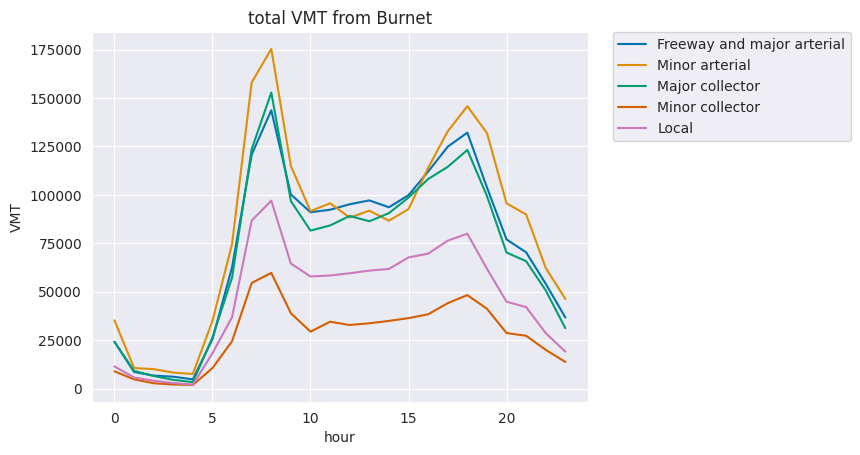

File /tmp/pycharm_project_316/BEAM_Freight/Output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Freight/plot/modeled_VMT_by_hour_Burnet.png uploaded to output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Output/plot/modeled_VMT_by_hour_Burnet.png.


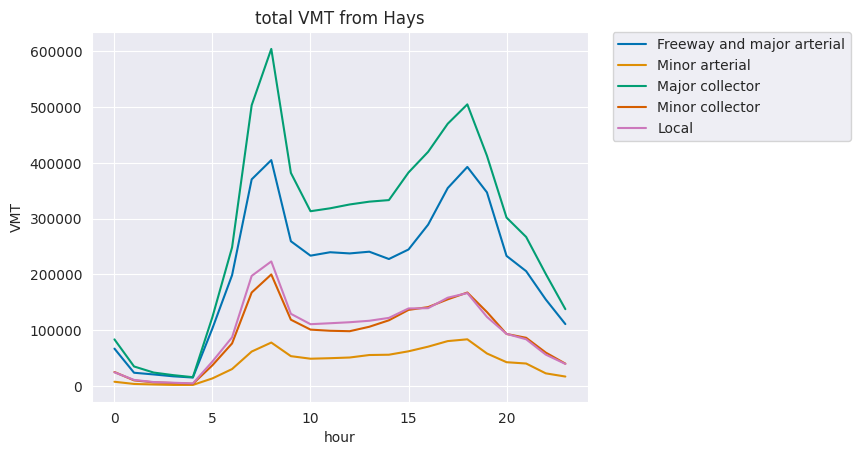

File /tmp/pycharm_project_316/BEAM_Freight/Output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Freight/plot/modeled_VMT_by_hour_Hays.png uploaded to output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Output/plot/modeled_VMT_by_hour_Hays.png.


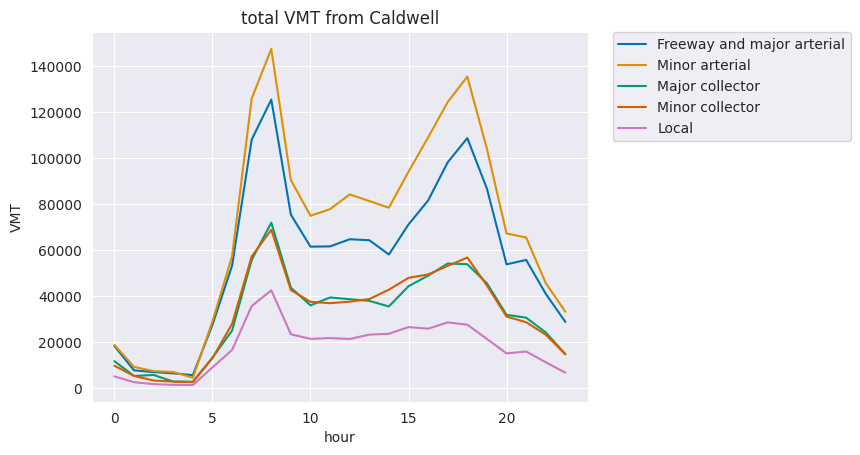

File /tmp/pycharm_project_316/BEAM_Freight/Output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Freight/plot/modeled_VMT_by_hour_Caldwell.png uploaded to output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Output/plot/modeled_VMT_by_hour_Caldwell.png.


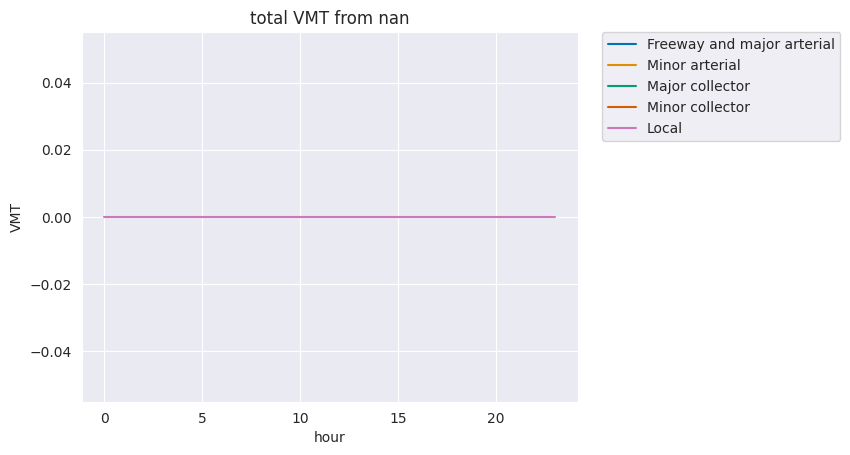

File /tmp/pycharm_project_316/BEAM_Freight/Output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Freight/plot/modeled_VMT_by_hour_nan.png uploaded to output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Output/plot/modeled_VMT_by_hour_nan.png.


In [13]:
model_vmt_24_hour['name'] = model_vmt_24_hour['name'].astype(str)
model_vmt_24_hour = model_vmt_24_hour.loc[model_vmt_24_hour['name'] != '']
list_of_counties = model_vmt_24_hour.name.unique()
for county in list_of_counties:
    # print(county)
    #     if county == '':
    #         continue
    model_vmt_by_county = model_vmt_24_hour.loc[model_vmt_24_hour['name'] == county]
    model_vmt_by_hour_county = model_vmt_by_county.groupby(['hour', 'road_class'])[['VMT']].sum()
    model_vmt_by_hour_county = model_vmt_by_hour_county.reset_index()
    sns.lineplot(x = 'hour', y = 'VMT', hue = 'road_class',data = model_vmt_by_hour_county, errorbar = None,hue_order=orders)
    # plt.ylim([0, 75])
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title('total VMT from ' + county)
    plt_file_name = f'modeled_VMT_by_hour_{county}.png'
    plt.savefig(project_folder.joinpath("Output", city_name, simulation_name, analysis_type,"plot",plt_file_name),
                dpi = 600, bbox_inches= 'tight')
    plt.show()
    bucket_name = "beam-core-outputs"
    source_file_name = project_folder.joinpath("Output", city_name, simulation_name, analysis_type, "plot",plt_file_name)
    destination_blob_name = f"output/{city_name}/{simulation_name}/Output/plot/{plt_file_name}"
    # Check if the file exist in the bucket. If "Yes", delete
    try:
        delete_blob(_bucket_name=bucket_name, _blob_name=destination_blob_name)
    except:
        pass
    # and upload the file
    upload_blob(bucket_name, source_file_name, destination_blob_name)

In [14]:
model_vmt_24_hour_nolocal = model_vmt_24_hour.loc[model_vmt_24_hour['road_class'] != 'Local']
model_vmt_by_county = model_vmt_24_hour_nolocal.groupby(['name'])[['VMT']].sum()
model_vmt_by_county = model_vmt_by_county.reset_index()
model_vmt_by_county

observed_vmt_by_county = observed_vmt.groupby('name')[['PVMT']].sum()
observed_vmt_by_county = observed_vmt_by_county.reset_index()

modeled_VMT     2.129860e+08
observed_VMT    5.389448e+07
dtype: float64


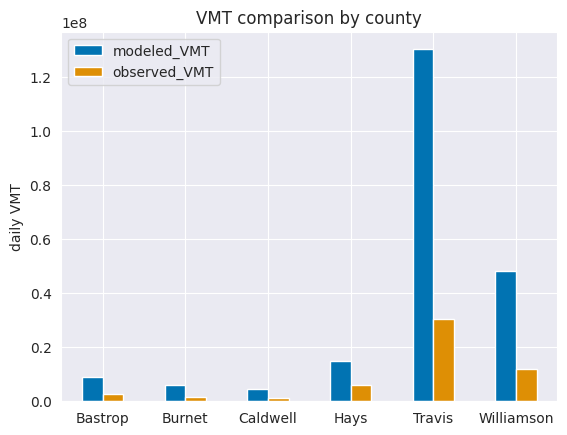

File /tmp/pycharm_project_316/BEAM_Freight/Output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Freight/plot/VMT_comparison_by_county.png uploaded to output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Output/plot/VMT_comparison_by_county.png.


In [15]:
VMT_comparison = pd.merge(model_vmt_by_county, observed_vmt_by_county,
                          on = 'name', how = 'left')
VMT_comparison = VMT_comparison.loc[:, ['name', 'VMT', 'PVMT']]
VMT_comparison.columns = ['county', 'modeled_VMT', 'observed_VMT']
VMT_comparison = VMT_comparison.loc[~VMT_comparison['county'].isin(['Santa Cruz', 'Yolo'])]
print(VMT_comparison.loc[:, ['modeled_VMT', 'observed_VMT']].sum())

VMT_comparison.plot.bar(x = 'county')
plt.xlabel('')
plt.ylabel('daily VMT')
plt.xticks(rotation=0, ha='center')
plt.title('VMT comparison by county')
plt_file_name = f'VMT_comparison_by_county.png'
plt.savefig(project_folder.joinpath("Output", city_name, simulation_name, analysis_type,"plot", plt_file_name),
            dpi = 600, bbox_inches= 'tight')
# plt.savefig('plot/' + scenario_name + '/VMT_comparison_by_county.png', dpi = 200, bbox_inches = 'tight')
plt.show()

bucket_name = "beam-core-outputs"
source_file_name = project_folder.joinpath("Output", city_name, simulation_name, analysis_type, "plot",plt_file_name)
destination_blob_name = f"output/{city_name}/{simulation_name}/Output/plot/{plt_file_name}"
# Check if the file exist in the bucket. If "Yes", delete
try:
    delete_blob(_bucket_name=bucket_name, _blob_name=destination_blob_name)
except:
    pass
# and upload the file
upload_blob(bucket_name, source_file_name, destination_blob_name)

In [16]:
model_vmt_by_roadtype = model_vmt_24_hour.groupby(['road_class'])[['VMT']].sum()
model_vmt_by_roadtype = model_vmt_by_roadtype.reset_index()
observed_vmt_by_roadtype = observed_vmt.groupby(['road_class'])[['PVMT']].sum()
observed_vmt_by_roadtype = observed_vmt_by_roadtype.reset_index()
VMT_comparison_by_roadtype = pd.merge(model_vmt_by_roadtype, observed_vmt_by_roadtype,
                                      on='road_class', how='left')
# VMT_comparison = VMT_comparison.loc[:, ['name', 'VMT', 'PVMT']]
VMT_comparison_by_roadtype.columns = ['road_class', 'modeled_VMT', 'observed_VMT']
VMT_comparison_by_roadtype

,road_class,modeled_VMT,observed_VMT
0,Freeway and major arterial,9.966904e+07,3.457537e+07
1,Local,1.993558e+07,NaN
2,Major collector,5.620328e+07,1.148540e+07
3,Minor arterial,3.628002e+07,7.833703e+06
4,Minor collector,2.083368e+07,NaN


In [17]:
# wrap x-axis labels
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                                    break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)

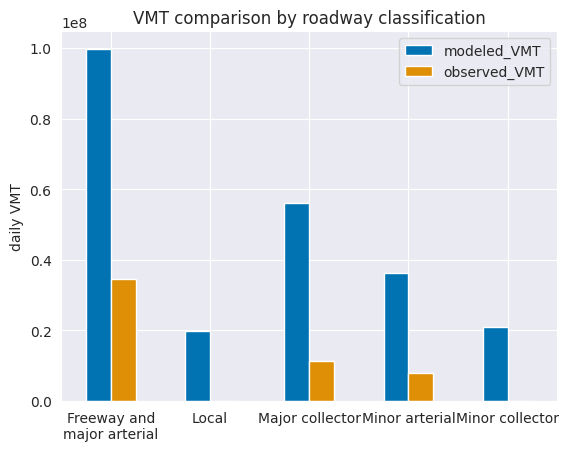

File /tmp/pycharm_project_316/BEAM_Freight/Output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Freight/plot/VMT_comparison_by_roadway_type.png uploaded to output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Output/plot/VMT_comparison_by_roadway_type.png.


In [18]:
import textwrap
fig, ax = plt.subplots()
VMT_comparison_by_roadtype.plot.bar(x = 'road_class',ax=ax)
plt.xlabel('')
plt.ylabel('daily VMT')
plt.title('VMT comparison by roadway classification')
# plt.xticks(rotation = 60)
plt.xticks(rotation=0, ha='center')
wrap_labels(ax, 15)
plt_file_name=f'VMT_comparison_by_roadway_type.png'
plt.savefig(project_folder.joinpath("Output", city_name, simulation_name, analysis_type,"plot", plt_file_name),
            dpi = 600, bbox_inches= 'tight')
# plt.savefig('plot/' + scenario_name + '/VMT_comparison_by_roadway_type.png', dpi = 200, bbox_inches = 'tight')
plt.show()

bucket_name = "beam-core-outputs"
source_file_name = project_folder.joinpath("Output", city_name, simulation_name, analysis_type, "plot",plt_file_name)
destination_blob_name = f"output/{city_name}/{simulation_name}/Output/plot/{plt_file_name}"
# Check if the file exist in the bucket. If "Yes", delete
try:
    delete_blob(_bucket_name=bucket_name, _blob_name=destination_blob_name)
except:
    pass
# and upload the file
upload_blob(bucket_name, source_file_name, destination_blob_name)

/tmp/ipykernel_88707/4143549004.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.0f}%'.format(x*100) for x in ax.get_yticks()])


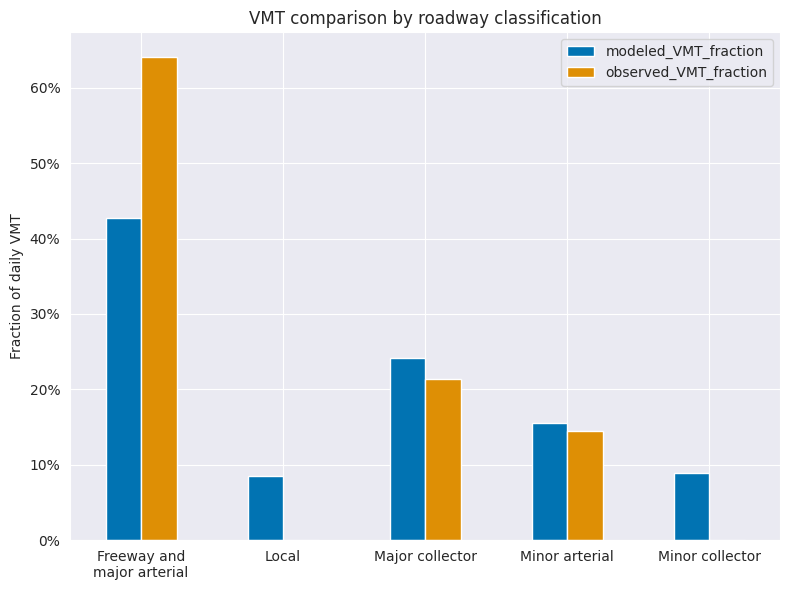

File /tmp/pycharm_project_316/BEAM_Freight/Output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Freight/plot/percent_VMT_comparison_by_roadway_type.png uploaded to output/austin/austin-base-with-freight-2018__2023-04-14_16-11-13_yoq/Output/plot/percent_VMT_comparison_by_roadway_type.png.


In [19]:
VMT_comparison_by_roadtype.loc[:, 'modeled_VMT_fraction'] = VMT_comparison_by_roadtype.loc[:, 'modeled_VMT'] / VMT_comparison_by_roadtype.loc[:, 'modeled_VMT'].sum()
VMT_comparison_by_roadtype.loc[:, 'observed_VMT_fraction'] = VMT_comparison_by_roadtype.loc[:, 'observed_VMT'] / VMT_comparison_by_roadtype.loc[:, 'observed_VMT'].sum()
percent_VMT_comparison_by_roadtype = VMT_comparison_by_roadtype.loc[:, ['road_class', 'modeled_VMT_fraction', 'observed_VMT_fraction']]

import matplotlib.ticker as mtick
# plt.figure(figsize = (12,8))
ax = percent_VMT_comparison_by_roadtype.plot.bar(x = 'road_class',figsize = (8,6))
# ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
plt.xlabel('')
plt.xticks(rotation = 45)
ax.set_yticklabels(['{:.0f}%'.format(x*100) for x in ax.get_yticks()])
# vals = ax.get_yticks()
# ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
wrap_labels(ax, 15)
plt.ylabel('Fraction of daily VMT')
plt.title('VMT comparison by roadway classification')
plt.xticks(rotation=0, ha='center')
plt.tight_layout()
plt_file_name=f'percent_VMT_comparison_by_roadway_type.png'
plt.savefig(project_folder.joinpath("Output", city_name, simulation_name, analysis_type,"plot",plt_file_name),
            dpi = 600, bbox_inches= 'tight')
# plt.savefig('plot/' + scenario_name + '/percent_VMT_comparison_by_roadway_type.png', dpi = 200)
plt.show()

bucket_name = "beam-core-outputs"
source_file_name = project_folder.joinpath("Output", city_name, simulation_name, analysis_type, "plot",plt_file_name)
destination_blob_name = f"output/{city_name}/{simulation_name}/Output/plot/{plt_file_name}"
# Check if the file exist in the bucket. If "Yes", delete
try:
    delete_blob(_bucket_name=bucket_name, _blob_name=destination_blob_name)
except:
    pass
# and upload the file
upload_blob(bucket_name, source_file_name, destination_blob_name)

<Axes: xlabel='attributeOrigType'>

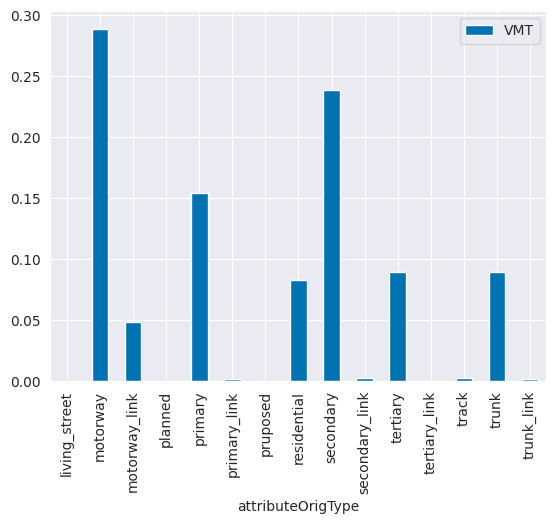

In [20]:
model_vmt_by_osmtype = model_vmt_24_hour.groupby(['attributeOrigType'])[['VMT']].sum()
model_vmt_by_osmtype.loc[:, 'VMT'] /= model_vmt_by_osmtype.loc[:, 'VMT'].sum()
model_vmt_by_osmtype.plot.bar()